# Set up correct environment variables 
Use default settings for buckets and paths

In [5]:
BUCKET = "sagemaker-domain-dev"
USER_DATA = "lauren-sso"
ARTIFACT_DATA = "artifacts"
KMS_KEY_ARN = "arn:aws:kms:us-east-2:642693618675:key/fcc40d6b-e6e3-40e8-8128-d7fc136539f7"

# Project title :- Bike Renting using Python 

**Problem statement :-**

The objective of this Case is to Predication of bike rental count on daily based on the environmental and seasonal settings.

**Contents :-**
             
        1. Exploratory Data Analysis
           * Loading the dataset and libraries
           * Data cleaning
           * Typecasting the attributes
           * Missing value analysis
        2. Attributes distributions and trends
           * Monthly distribution of counts
           * Yearly distribution of counts
           * Outliers analysis
        3. Normality test
        4. Correlation matrix 
        5. Split the dataset into train and test dataset
        6. Encoding the categorical features
        7. Modelling the training dataset
           * Linear Regression Model
           * Decision Tree Regressor Model
           * Random Forest Model
        8. Cross Validation Prediction
           * Linear Regression CV Prediction
           * Decision Tree Regressor CV Prediction
           * Random Forest CV Prediction
        9. Model performance on test dataset
           * Linear Regression Prediction
           * Decision Tree Regressor Prediction
           * Random Forest Prediction
        10. Model Evaluation Metrics
           * R-squared score
           * Root mean square error
           * Mean absolute error
        11.Choosing best model for predicting bike rental count

**Exploratory Data Analysis**

**Import the required libraries**

In [6]:
!pip install seaborn

In [7]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import os
import sagemaker
from sagemaker.feature_store.feature_group import FeatureGroup, FeatureDefinition, FeatureTypeEnum
from sagemaker import get_execution_role
import boto3



In [8]:
# Read CSV
s3 = boto3.client('s3', "us-east-2")

# Read the file from the local filesystem
with open("day.csv", 'rb') as file_data:
    # Upload the file to S3
    s3.upload_fileobj(file_data, Bucket=BUCKET, Key=f"{USER_DATA}/day.csv",         
        ExtraArgs={
            'ServerSideEncryption': 'aws:kms',
            'SSEKMSKeyId': KMS_KEY_ARN
        })

In [9]:
read_file = s3.get_object(Bucket=BUCKET, Key=f"{USER_DATA}/day.csv")
bike_df = pd.read_csv(read_file['Body'],sep=',')

bike_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


**Read the training data**

**Shape of the dataset**

In [10]:
#Shape of the dataset
bike_df.shape

(730, 16)

The dataset contains 731 observations and 16 attributes.

**Data types**

In [11]:
#Data types
bike_df.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [12]:
#Read the data
bike_df.head(5)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


**Rename the columns for better understanding of variables**

In [13]:
#Rename the columns
bike_df.rename(columns={'instant':'rec_id','dteday':'datetime','yr':'year','mnth':'month','weathersit':'weather_condition',
                       'hum':'humidity','cnt':'total_count'},inplace=True)

In [14]:
#Read the data
bike_df.head(5)

,rec_id,datetime,season,year,month,holiday,weekday,workingday,weather_condition,temp,atemp,humidity,windspeed,casual,registered,total_count
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


**Typecasting the datetime and numerical attributes**

In [15]:
#Type casting the datetime and numerical attributes to category

bike_df['datetime']=pd.to_datetime(bike_df.datetime, format="%d-%m-%Y")

bike_df['season']=bike_df.season.astype('category')
bike_df['year']=bike_df.year.astype('category')
bike_df['month']=bike_df.month.astype('category')
bike_df['holiday']=bike_df.holiday.astype('category')
bike_df['weekday']=bike_df.weekday.astype('category')
bike_df['workingday']=bike_df.workingday.astype('category')
bike_df['weather_condition']=bike_df.weather_condition.astype('category')

In [16]:
#Summary of the dataset
bike_df.describe()

,rec_id,datetime,temp,atemp,humidity,windspeed,casual,registered,total_count
count,730.000000,730,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2018-12-31 12:00:00,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
min,1.000000,2018-01-01 00:00:00,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2018-07-02 06:00:00,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,2018-12-31 12:00:00,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,2019-07-01 18:00:00,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,2019-12-31 00:00:00,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000
std,210.877136,NaN,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647


**Missing value analysis**

No missing values present in training dataset.

In [17]:
#Missing values in dataset
bike_df.isnull().sum()

rec_id               0
datetime             0
season               0
year                 0
month                0
holiday              0
weekday              0
workingday           0
weather_condition    0
temp                 0
atemp                0
humidity             0
windspeed            0
casual               0
registered           0
total_count          0
dtype: int64

**Attributes distributions and trends**

**Monthly distribution of counts**

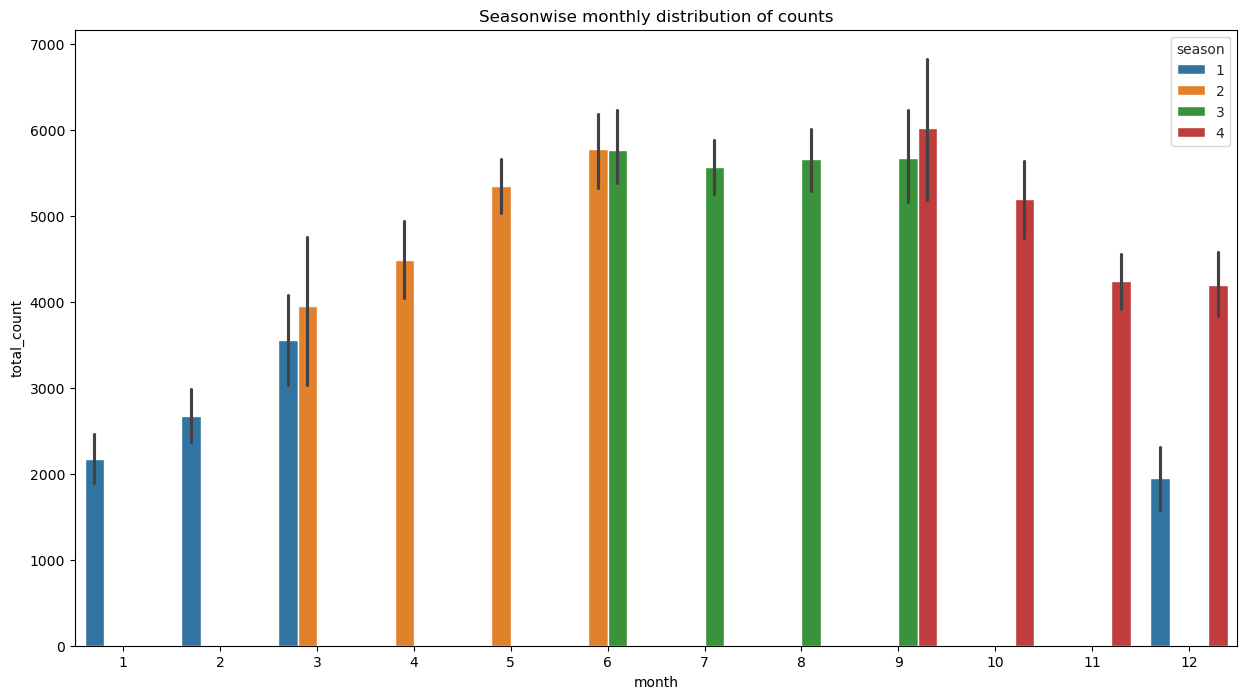

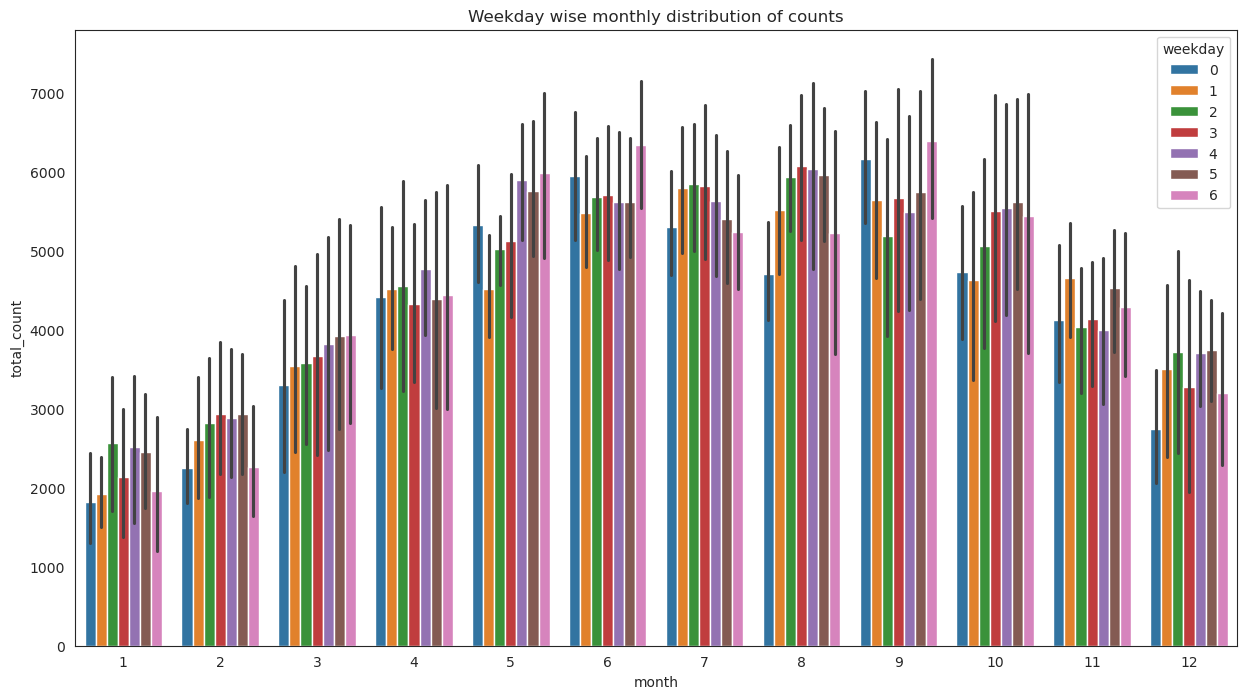

In [18]:
fig,ax=plt.subplots(figsize=(15,8))
sns.set_style('white')
#Bar plot for seasonwise monthly distribution of counts
sns.barplot(x='month',y='total_count',data=bike_df[['month','total_count','season']],hue='season',ax=ax)
ax.set_title('Seasonwise monthly distribution of counts')
plt.show()
#Bar plot for weekday wise monthly distribution of counts
fig,ax1=plt.subplots(figsize=(15,8))
sns.barplot(x='month',y='total_count',data=bike_df[['month','total_count','weekday']],hue='weekday',ax=ax1)
ax1.set_title('Weekday wise monthly distribution of counts')
plt.show()

From the above plots, we can observed that increasing the bike rental count in springe and summer season and then decreasing the bike rental count in fall and winter season.
Here, 

season 1-> spring season 2 -> summer season 3 -> fall season 4 -> winter

**Yearly wise distribution of counts**

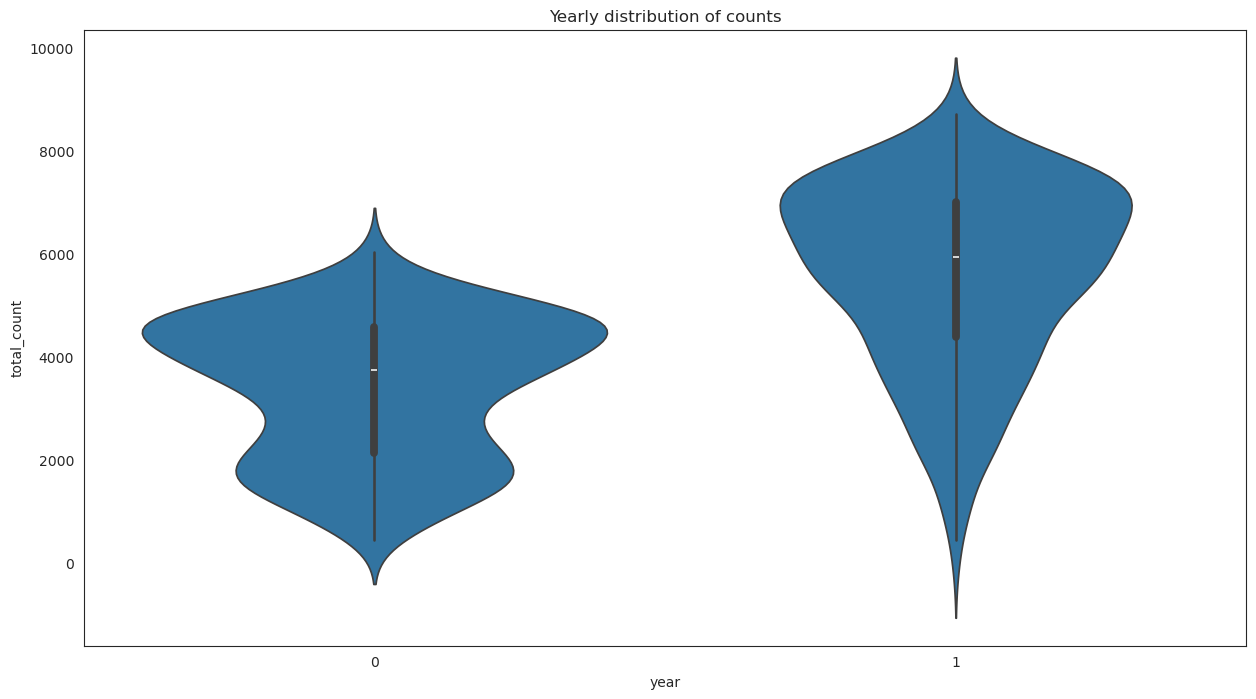

In [19]:
fig,ax=plt.subplots(figsize=(15,8))
#Violin plot for yearly distribution of counts
sns.violinplot(x='year',y='total_count',data=bike_df[['year','total_count']])
ax.set_title('Yearly distribution of counts')
plt.show()

From the violin plot, we can observed that the bike rental count distribution is highest in year 2012 then in year 2011. 

Here,  
year 0-> 2011, year 1-> 2012

**Holiday wise distribution of counts**

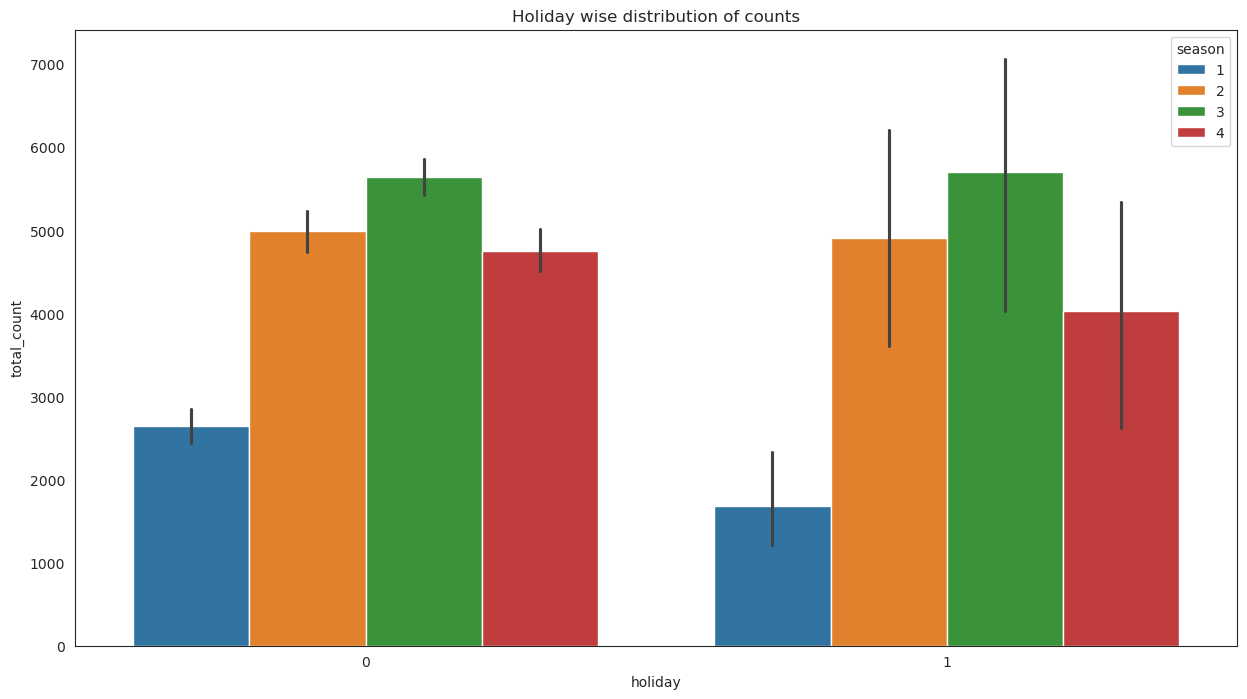

In [20]:
fig,ax=plt.subplots(figsize=(15,8))
#Barplot for Holiday distribution of counts
sns.barplot(data=bike_df,x='holiday',y='total_count',hue='season')
ax.set_title('Holiday wise distribution of counts')
plt.show()

From the above bar plot, we can observed that during no holiday the bike rental counts is highest compared to during holiday for different seasons.

Here, 0->No holiday, 1-> holiday

**Workingday wise distribution of counts**

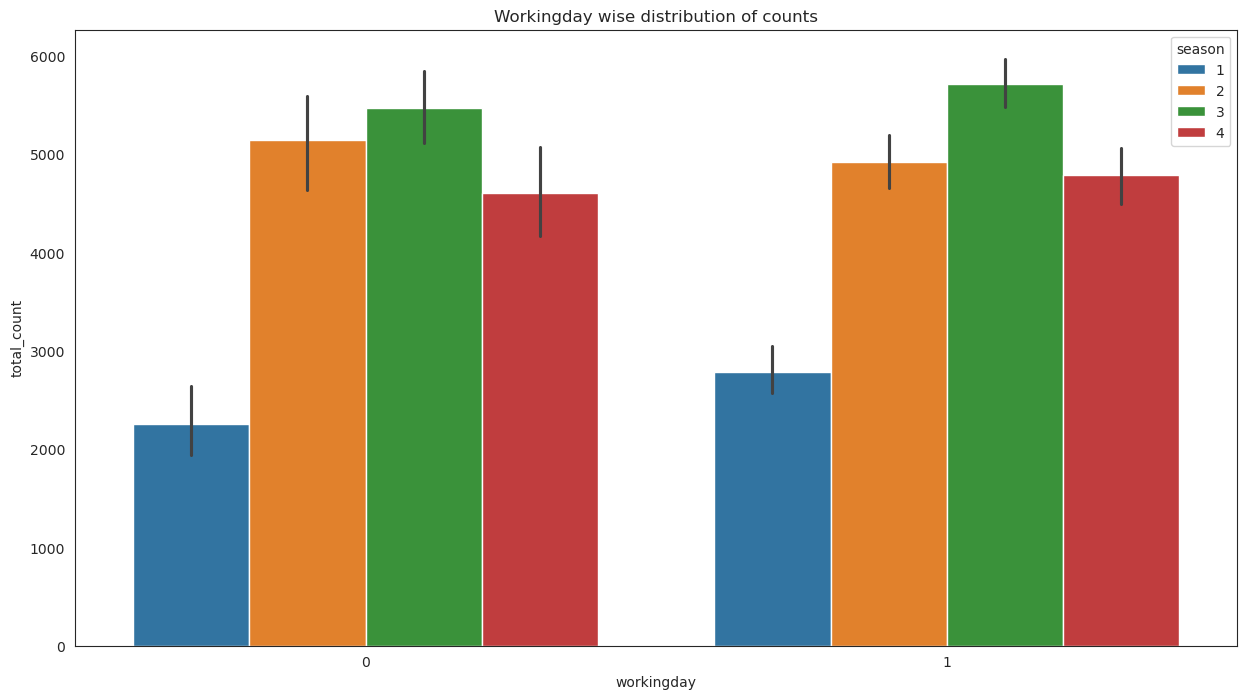

In [21]:
fig,ax=plt.subplots(figsize=(15,8))
#Bar plot for workingday distribution of counts
sns.barplot(data=bike_df,x='workingday',y='total_count',hue='season')
ax.set_title('Workingday wise distribution of counts')
plt.show()

From the above bar plot, we can observed that during workingday the bike rental counts is quite highest compared to during no workingday for different seasons.

Here, 0-> No workingday, 1-> workingday

**Weather_condition distribution of counts**

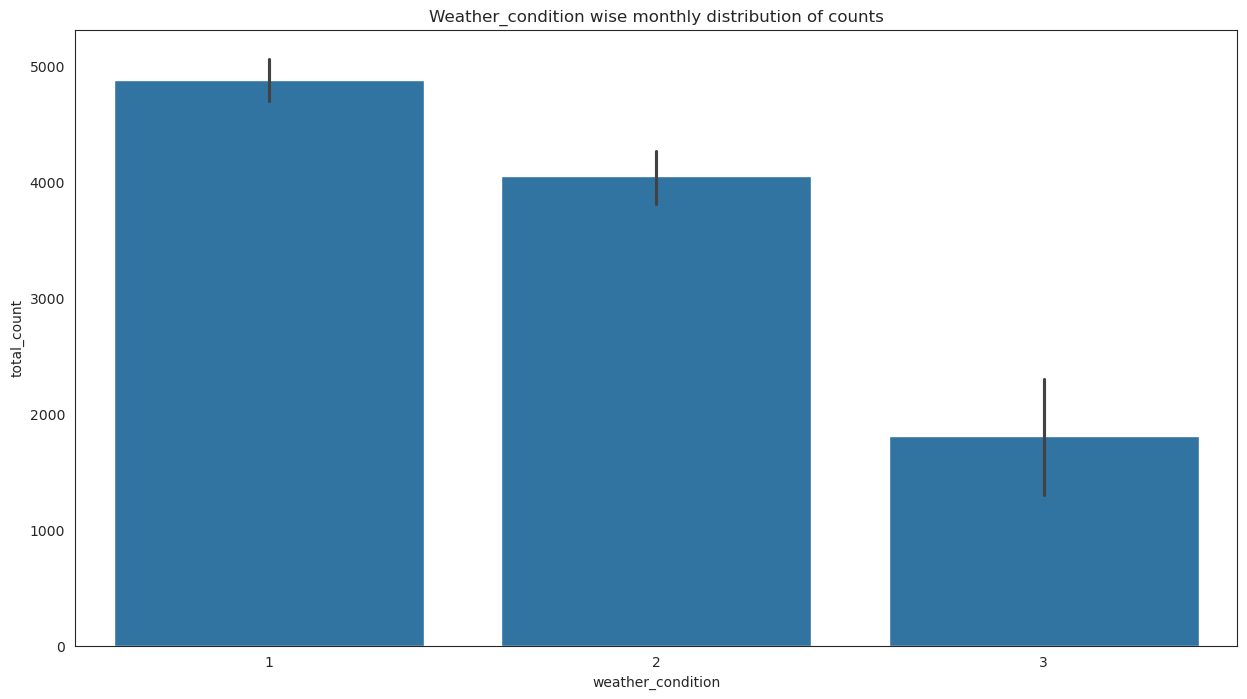

In [22]:
fig,ax1=plt.subplots(figsize=(15,8))
#Bar plot for weather_condition distribution of counts
sns.barplot(x='weather_condition',y='total_count',data=bike_df[['month','total_count','weather_condition']],ax=ax1)
ax1.set_title('Weather_condition wise monthly distribution of counts')
plt.show()

From the above bar plot, we can observed that during clear,partly cloudy weather the bike rental count is highest and the second highest is during mist cloudy weather and followed by third highest during light snow and light rain weather.

**Outlier analysis**

**Total_Count_Outliers**

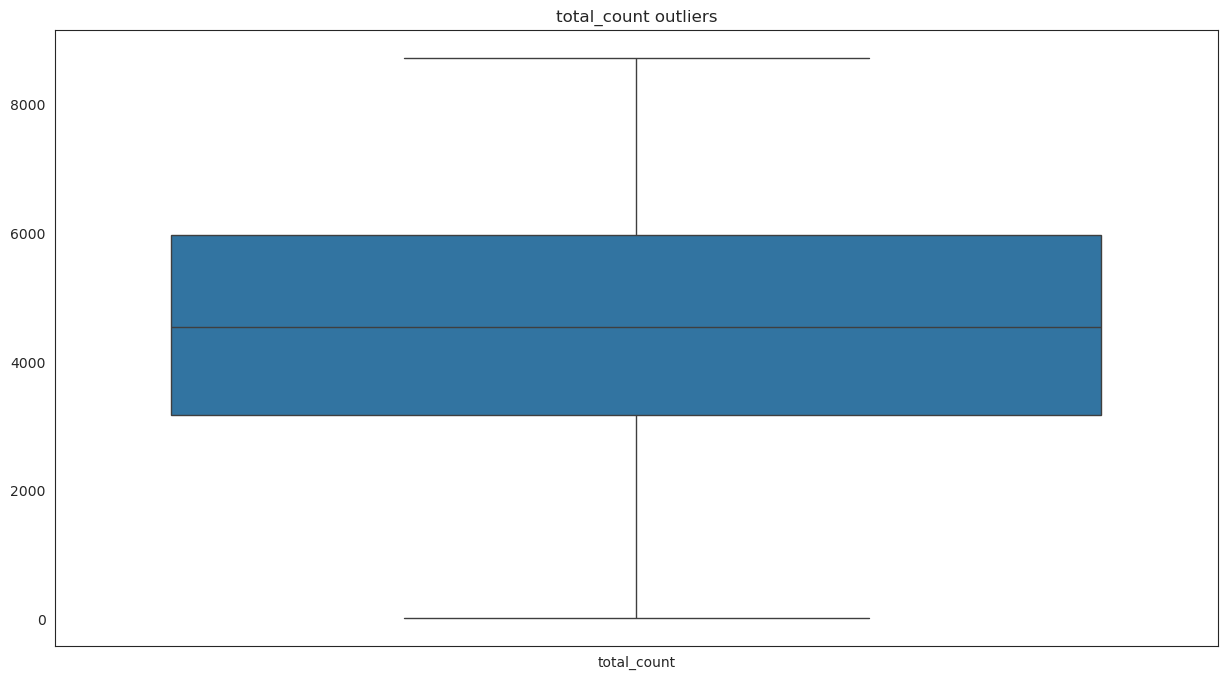

In [23]:
fig,ax=plt.subplots(figsize=(15,8))
#Boxplot for total_count outliers
sns.boxplot(data=bike_df[['total_count']])
ax.set_title('total_count outliers')
plt.show()

From the box plot, we can observed that no outliers are present in total_count variable.

**Temp_windspeed_humidity_outliers**

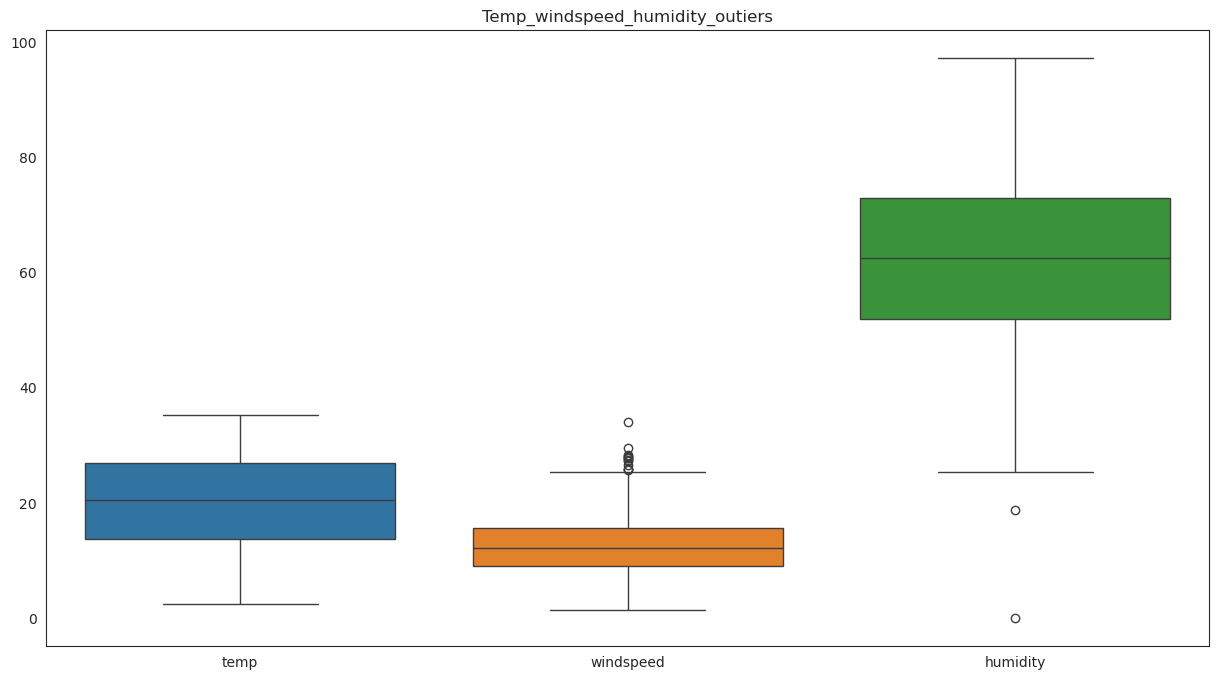

In [24]:
fig,ax=plt.subplots(figsize=(15,8))
#Box plot for Temp_windspeed_humidity_outliers
sns.boxplot(data=bike_df[['temp','windspeed','humidity']])
ax.set_title('Temp_windspeed_humidity_outiers')
plt.show()

From the box plot, we can observed that no outliers are present in normalized temp but few outliers are present in normalized windspeed and humidity variable.

**Replace and impute the outliers**

In [25]:

#create dataframe for outliers
wind_hum=pd.DataFrame(bike_df,columns=['windspeed','humidity'])
 #Cnames for outliers                     
cnames=['windspeed','humidity']       
                      
for i in cnames:
    q75,q25=np.percentile(wind_hum.loc[:,i],[75,25]) # Divide data into 75%quantile and 25%quantile.
    iqr=q75-q25 #Inter quantile range
    min=q25-(iqr*1.5) #inner fence
    max=q75+(iqr*1.5) #outer fence
    wind_hum.loc[wind_hum.loc[:,i]<min,:i]=np.nan  #Replace with NA
    wind_hum.loc[wind_hum.loc[:,i]>max,:i]=np.nan  #Replace with NA
#Imputating the outliers by mean Imputation
wind_hum['windspeed']=wind_hum['windspeed'].fillna(wind_hum['windspeed'].mean())
wind_hum['humidity']=wind_hum['humidity'].fillna(wind_hum['humidity'].mean())

**Replace the original dataset to imputated data**

In [26]:
#Replacing the imputated windspeed
bike_df['windspeed']=bike_df['windspeed'].replace(wind_hum['windspeed'])
#Replacing the imputated humidity
bike_df['humidity']=bike_df['humidity'].replace(wind_hum['humidity'])
bike_df.head(5)

,rec_id,datetime,season,year,month,holiday,weekday,workingday,weather_condition,temp,atemp,humidity,windspeed,casual,registered,total_count
0,1,2018-01-01,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,2018-01-02,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,2018-01-03,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,2018-01-04,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,2018-01-05,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


**Normal Probability Plot**

Normal probability plot is a graphical technique to identify substantive departures from normality and also it tells about goodness of fit.

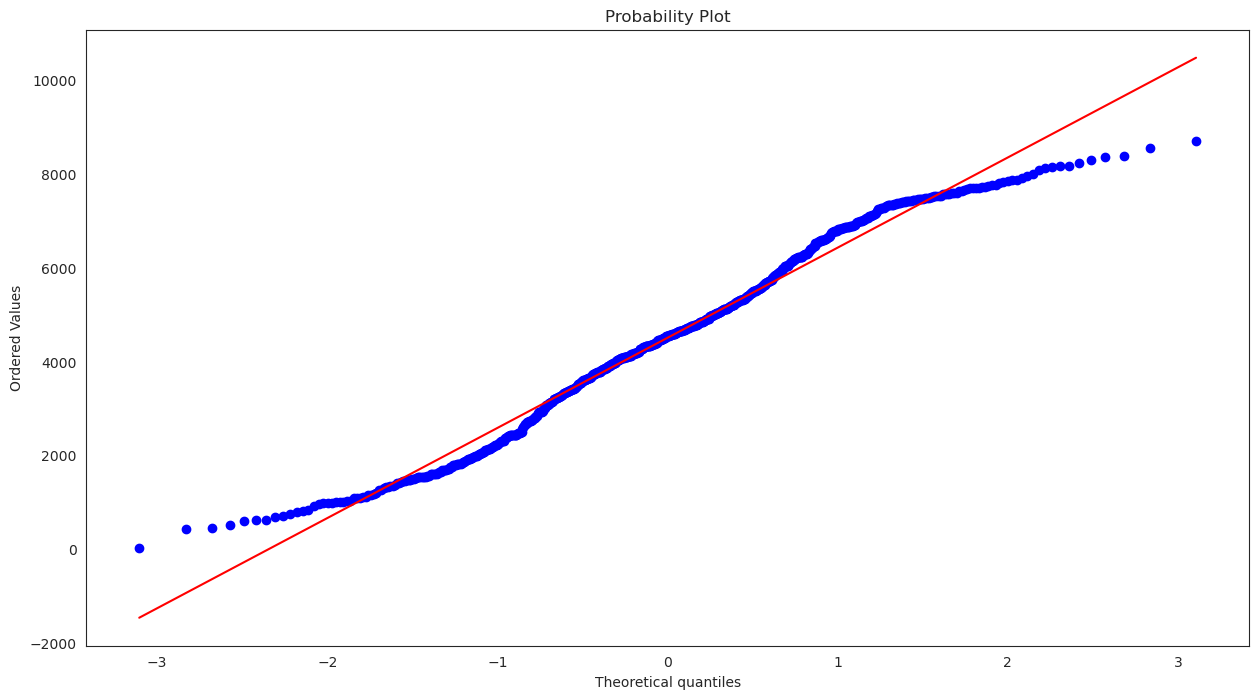

In [27]:
import scipy
from scipy import stats
#Normal plot
fig=plt.figure(figsize=(15,8))
stats.probplot(bike_df.total_count.tolist(),dist='norm',plot=plt)
plt.show()

The above probability plot, the some target variable data points are deviates from normality.

**Correlation matrix**

Correlation matrix is tells about linear relationship between attributes and help us to build better models.

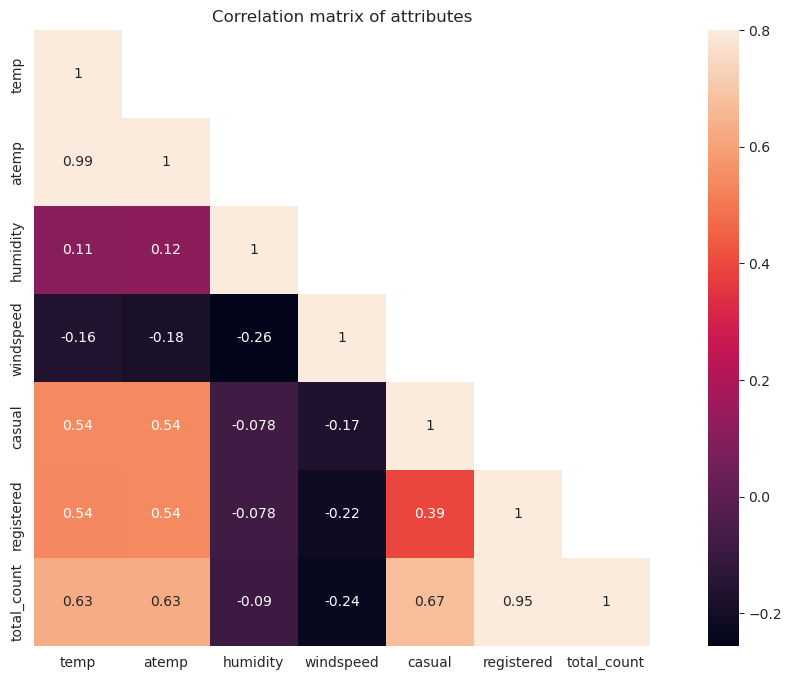

In [28]:
#Create the correlation matrix
correMtr=bike_df[["temp","atemp","humidity","windspeed","casual","registered","total_count"]].corr()
mask=np.array(correMtr)
mask[np.tril_indices_from(mask)]=False
#Heat map for correlation matrix of attributes
fig,ax=plt.subplots(figsize=(15,8))
sns.heatmap(correMtr,mask=mask,vmax=0.8,square=True,annot=True,ax=ax)
ax.set_title('Correlation matrix of attributes')
plt.show()

From correlation plot, we can observed that some features are positively correlated or some are negatively correlated to each other. The temp and atemp are highly positively correlated to each other, it means that both are carrying same information.The total_count,casual and registered are highly positively correlated to each other. So, we are going to ignore atemp,casual and registered variable for further analysis.

**Modelling the dataset**

In [29]:
#load the required libraries
from sklearn import preprocessing,metrics,linear_model
from sklearn.model_selection import cross_val_score,cross_val_predict,train_test_split

Split the dataset into train and test in the ratio of 70:30

In [30]:
#Split the dataset into the train and test data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(bike_df.iloc[:,0:-3],bike_df.iloc[:,-1],test_size=0.3, random_state=42)

#Reset train index values
X_train.reset_index(inplace=True)
y_train=y_train.reset_index()

# Reset train index values
X_test.reset_index(inplace=True)
y_test=y_test.reset_index()

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
print(y_train.head())
print(y_test.head())

(511, 14) (219, 14) (511, 2) (219, 2)
   index  total_count
0    683         5445
1    645         5478
2    163         5020
3    360         1162
4    640         7572
   index  total_count
0    468         7460
1    148         4788
2    302         3331
3    355         3068
4    515         7338


**Split the features into categorical and numerical features**

In [31]:
#Create a new dataset for train attributes
train_attributes=X_train[['season','month','year','weekday','holiday','workingday','weather_condition','humidity','temp','windspeed']]
#Create a new dataset for test attributes
test_attributes=X_test[['season','month','year','weekday','holiday','workingday','humidity','temp','windspeed','weather_condition']]
#categorical attributes
cat_attributes=['season','holiday','workingday','weather_condition','year']
#numerical attributes
num_attributes=['temp','windspeed','humidity','month','weekday']

**Decoding the training attributes**

In [32]:
#To get dummy variables to encode the categorical features to numeric
train_encoded_attributes=pd.get_dummies(train_attributes,columns=cat_attributes)
print('Shape of transfomed dataframe::',train_encoded_attributes.shape)

train_encoded_attributes.head(5)

Shape of transfomed dataframe:: (511, 18)


,month,weekday,humidity,temp,windspeed,season_1,season_2,season_3,season_4,holiday_0,holiday_1,workingday_0,workingday_1,weather_condition_1,weather_condition_2,weather_condition_3,year_0,year_1
0,11,4,62.0417,13.188347,10.250129,False,False,False,True,True,False,False,True,False,True,False,False,True
1,10,1,70.9583,15.716653,12.708493,False,False,False,True,False,True,True,False,False,True,False,False,True
2,6,1,49.4583,26.035000,20.458450,False,True,False,False,True,False,False,True,True,False,False,True,False
3,12,2,76.2500,13.325000,12.626150,True,False,False,False,True,False,False,True,False,True,False,True,False
4,10,3,79.3750,26.957500,4.458569,False,False,False,True,True,False,False,True,False,True,False,False,True


**Training dataset**

In [33]:
#Training dataset for modelling
X_train=train_encoded_attributes
y_train=y_train.total_count.values

**Linear Regression Model**

In [34]:
#training model
lr_model=linear_model.LinearRegression()
lr_model

LinearRegression()

**fit the training model**

In [35]:
#fit the trained model
lr_model.fit(X_train,y_train)

LinearRegression()

**Accuracy of model**

In [36]:
#Accuracy of the model
lr=lr_model.score(X_train,y_train)
print('Accuracy of the model :',lr)
print('Model coefficients :',lr_model.coef_)
print('Model intercept value :',lr_model.intercept_)

Accuracy of the model : 0.8235146581358161
Model coefficients : [  -34.97049205    60.43458209    -8.71287554   121.73963622
   -37.09175176 -1067.52997878   220.84667408    11.86386013
   834.81944457   241.59235767  -241.59235767   -74.74603934
    74.74603934   802.85526546   297.38891277 -1100.24417823
  -991.82798863   991.82798863]
Model intercept value : 2232.8811280208697


**Cross validation prediction**

In [37]:
#Cross validation prediction
predict=cross_val_predict(lr_model,X_train,y_train,cv=3)
predict

array([ 5127.33627997,  4228.60957556,  4358.97511059,   951.82647252,
        6738.15993482,  5192.07541405,  5611.36685645,  4061.08303567,
        3410.02275908,  5435.02694728,  2998.54995338,  4319.70818682,
        5873.19497686,  4220.77446392,  6354.9734542 ,  7379.33197622,
        3312.98456935,   758.72590423,   572.30034427,  6663.03041178,
        7159.32121163,  4060.47042157,  5665.8336118 ,  6170.65459025,
        6332.34246093,  3520.52548661,  5126.90534824,  4870.44579026,
        1655.0133012 ,  1645.21643783,  1712.0629697 ,  1232.18698491,
        4892.45046667,  6325.65821334,  5980.80389078,  1985.70727338,
        1049.51602595,  1332.99158628,  5015.69407378,  6112.63928038,
        6335.22660425,  4116.81942975,  6443.74808089,  7281.74283424,
        3404.72966034,  6330.99960979,  1391.18793197,  5357.10648469,
        4585.61000719,  4093.39292219,  3357.7276068 ,  2904.09914501,
        4746.16332281,  6777.46256957,  5969.99397983,  2331.83970277,
      

**Cross validation prediction plot**

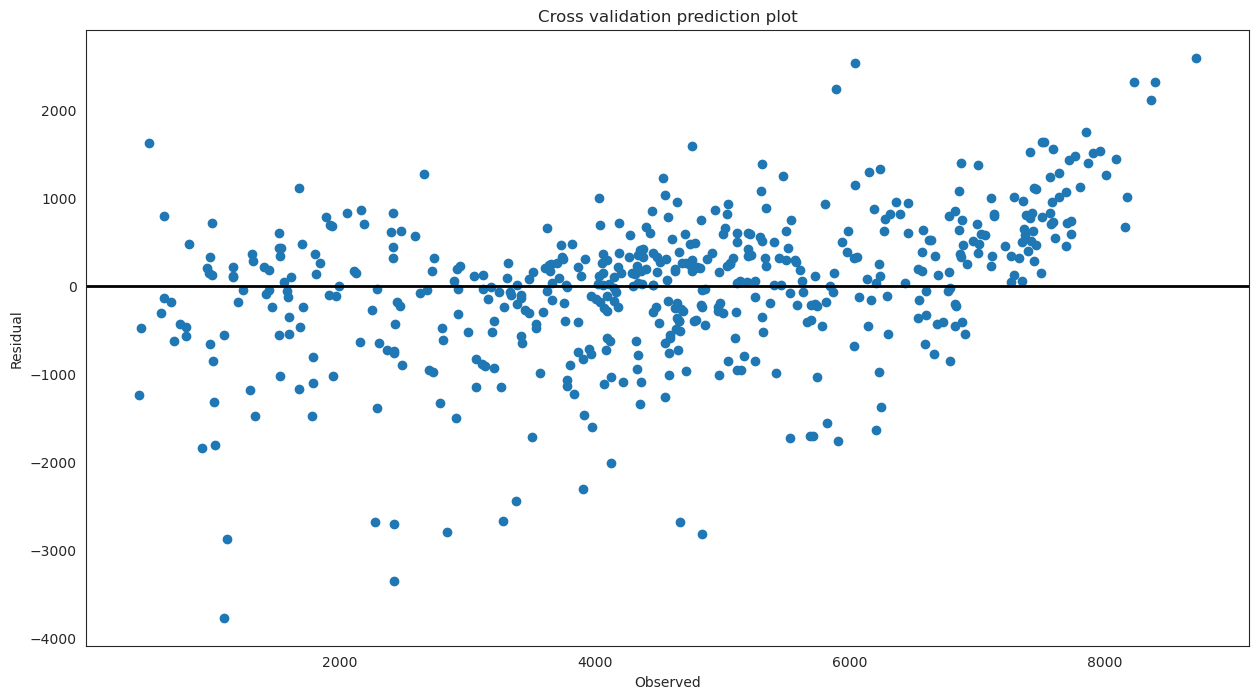

In [38]:
#Cross validation plot
fig,ax=plt.subplots(figsize=(15,8))
ax.scatter(y_train,y_train-predict)
ax.axhline(lw=2,color='black')
ax.set_title('Cross validation prediction plot')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()

Cross validation prediction plot tells about finite variance between actual target value and predicted target value. In this plot, some data points are have same finite variance between them and for some are not have it.

**Model evalution metrics**

**R-squared and mean squared error score**

In [39]:
#R-squared scores
r2_scores = cross_val_score(lr_model, X_train, y_train, cv=3)
print('R-squared scores :',np.average(r2_scores))

R-squared scores : 0.8113458473924906


The R-squared or coefficient of determination is 0.80 on average for 3-fold cross validation , it means that predictor is only able to predict 80% of the variance in the target variable which is contributed by independent variables.

**Decoding the test attributes**

In [40]:
#To get dummy variables to encode the categorical features to numeric
test_encoded_attributes=pd.get_dummies(test_attributes,columns=cat_attributes)
print('Shape of transformed dataframe :',test_encoded_attributes.shape)
test_encoded_attributes.head(5)

Shape of transformed dataframe : (219, 18)


,month,weekday,humidity,temp,windspeed,season_1,season_2,season_3,season_4,holiday_0,holiday_1,workingday_0,workingday_1,weather_condition_1,weather_condition_2,weather_condition_3,year_0,year_1
0,4,6,50.2917,20.295000,12.791439,False,True,False,False,True,False,True,False,True,False,False,False,True
1,5,0,81.8750,27.367500,14.333846,False,True,False,False,True,False,True,False,True,False,False,True,False
2,10,0,62.3750,13.085847,11.833339,False,False,False,True,True,False,True,False,True,False,False,True,False
3,12,4,75.7500,17.356653,3.167425,True,False,False,False,True,False,False,True,False,True,False,True,False
4,5,4,49.2917,27.880000,13.083693,False,True,False,False,True,False,False,True,True,False,False,False,True


**Model performance on test dataset**

In [41]:
#Test dataset for prediction
X_test=test_encoded_attributes
y_test=y_test.total_count.values

**Predict the model**

In [42]:
#predict the model
lr_pred=lr_model.predict(X_test)
lr_pred

array([6196.04661286, 4343.42428846, 3306.55061595, 1944.84985206,
       7110.96683875, 4669.77352708, 2098.22996151, 2570.11892772,
       3574.40348857, 3717.4014786 , 3014.66899407, 5045.86762577,
       1768.93908372, 3953.24671072, 5220.27615663, 3065.42472795,
       5776.45313988, 1325.95033476, 6088.43218144, 4294.11754971,
       3518.06685534, 4063.52153021, 4509.91665186, 5761.01268669,
       5233.52337804, 5208.93764229, 3727.80142777,  670.96798767,
       4939.9021794 , 1842.30786884, 3490.91253839, 3121.85019543,
       1204.59548476, 1226.01002727, 5425.0809158 , 5227.27610161,
       3221.1766013 , 3237.61334338,  815.60086314, 6746.23076099,
       1759.20738765, 5799.82964097, 5027.71078114, 6260.88717647,
       4740.34706134, 3447.80101989, 6296.38204948, 4985.5534277 ,
       4478.33471489, 6718.80789438, 3858.79799517, 4456.01833916,
       5853.88874918, 5474.62296493, 5491.10141876, 6916.25728827,
       3684.66222042, 6280.56707085, 4222.51238553, 5306.33393

**Model evaluation metrics**

**Root mean square error and mean absolute error scores**

In [43]:
import math
#Root mean square error 
rmse=math.sqrt(metrics.mean_squared_error(y_test,lr_pred))
#Mean absolute error
mae=metrics.mean_absolute_error(y_test,lr_pred)
print('Root mean square error :',rmse)
print('Mean absolute error :',mae)

Root mean square error : 802.4291866599555
Mean absolute error : 595.2441391283485


**Residual plot**

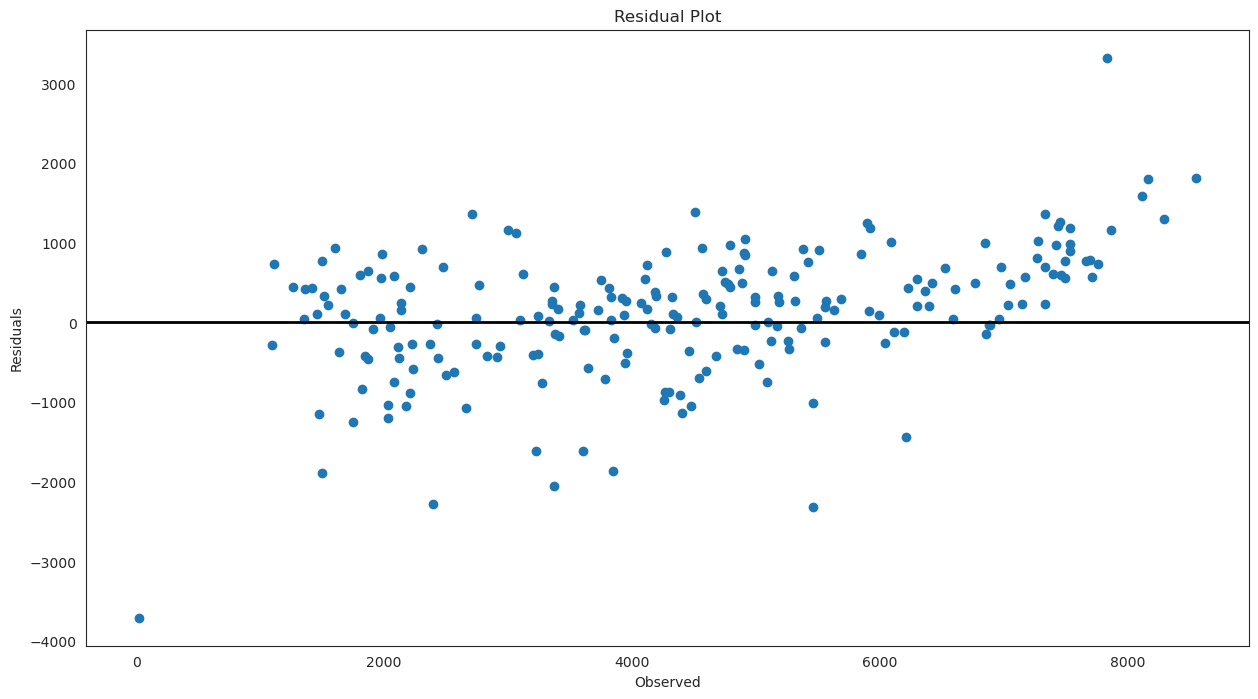

In [44]:
#Residual plot
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(y_test, y_test-lr_pred)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residuals')
ax.title.set_text("Residual Plot")
plt.show()

Residual plot tells about finite variance between actual target value and predicted target value.In this plot,very less data points are have same finite variance between them and for most are not have it.

**Decision tree regressor**

In [45]:
#training the model
from sklearn.tree import DecisionTreeRegressor
dtr=DecisionTreeRegressor(min_samples_split=2,max_leaf_nodes=10)

**Fit the model**

In [46]:
#Fit the trained model
dtr.fit(X_train,y_train)

DecisionTreeRegressor(max_leaf_nodes=10)

**Decision tree regression accuracy score**

In [47]:
#Accuracy score of the model
dtr_score=dtr.score(X_train,y_train)
print('Accuracy of model :',dtr_score)

Accuracy of model : 0.8080193854575297


**Plot the learned model**

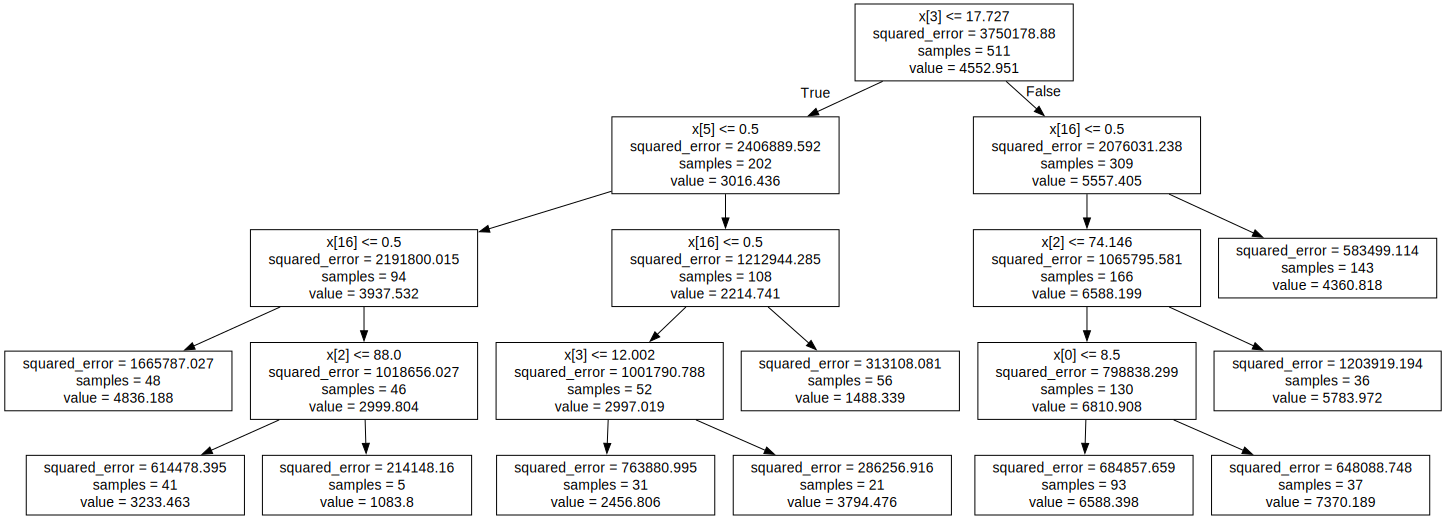

In [48]:
#Plot the learned model
from sklearn import tree
import graphviz

# export the learned model to tree
dot_data = tree.export_graphviz(dtr, out_file=None) 
graph = graphviz.Source(dot_data) 
graph

Cross validation prediction

In [49]:
predict=cross_val_predict(dtr,X_train,y_train,cv=3)
predict

array([5142.17948718, 5142.17948718, 4498.54761905, 1497.02941176,
       4910.09090909, 4910.09090909, 5142.17948718, 2920.32352941,
       2920.32352941, 5142.17948718, 2920.32352941, 4498.54761905,
       6835.        , 2920.32352941, 5142.17948718, 6835.        ,
       2920.32352941, 1497.02941176, 2920.32352941, 6835.        ,
       6835.        , 3875.625     , 1652.        , 4910.09090909,
       4910.09090909, 2328.45454545, 5142.17948718, 4498.54761905,
       1497.02941176, 1497.02941176, 1497.02941176, 1497.02941176,
       4498.54761905, 6835.        , 6835.        , 1497.02941176,
       1497.02941176, 2920.32352941, 4498.54761905, 6835.        ,
       6835.        , 4498.54761905, 6835.        , 6835.        ,
       4498.54761905, 5142.17948718, 1497.02941176, 5142.17948718,
       4498.54761905, 2920.32352941, 2920.32352941, 2328.45454545,
       6835.        , 6835.        , 6835.        , 2328.45454545,
       1497.02941176, 4498.54761905, 1497.02941176, 4498.54761

**Cross validation prediction plot**

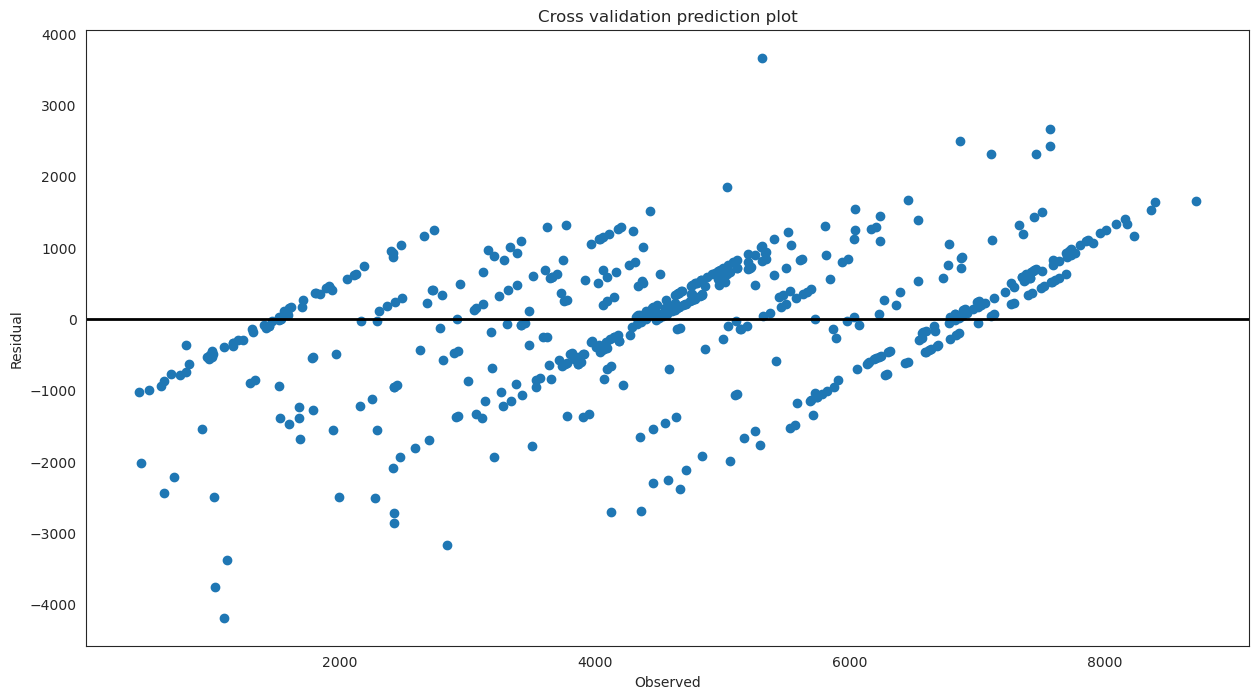

In [50]:
# Cross validation prediction plot
fig,ax=plt.subplots(figsize=(15,8))
ax.scatter(y_train,y_train-predict)
ax.axhline(lw=2,color='black')
ax.set_title('Cross validation prediction plot')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()

Cross validation prediction plot tells about finite variance between actual target value and predicted target value. In this plot,some data points are have same finite variance between them and for some are not have it.

**Model evalution metrics**

**R-squared and mean squared error scores**

In [51]:
#R-squared scores
r2_scores = cross_val_score(dtr, X_train, y_train, cv=3)
print('R-squared scores :',np.average(r2_scores))

R-squared scores : 0.752713472979149


The R-squared or coefficient of determination is 0.74 on average for 3-fold cross validation ,it means that predictor is only able to predict 74% of the variance in the target variable which is contributed by independent variables.

**Model performance on test dataset**

In [52]:
#predict the model
dtr_pred=dtr.predict(X_test)
dtr_pred

array([6588.39784946, 4360.81818182, 3233.46341463, 1488.33928571,
       6588.39784946, 4360.81818182, 1488.33928571, 3233.46341463,
       4360.81818182, 3233.46341463, 3233.46341463, 4836.1875    ,
       1488.33928571, 2456.80645161, 4360.81818182, 3233.46341463,
       6588.39784946, 1488.33928571, 6588.39784946, 4360.81818182,
       3794.47619048, 3794.47619048, 4360.81818182, 6588.39784946,
       4360.81818182, 4360.81818182, 4360.81818182, 1488.33928571,
       4360.81818182, 1488.33928571, 3233.46341463, 4360.81818182,
       1488.33928571, 1488.33928571, 5783.97222222, 4360.81818182,
       2456.80645161, 4360.81818182, 1488.33928571, 7370.18918919,
       1488.33928571, 4836.1875    , 4360.81818182, 7370.18918919,
       4360.81818182, 3233.46341463, 6588.39784946, 6588.39784946,
       4360.81818182, 6588.39784946, 3794.47619048, 4360.81818182,
       4836.1875    , 4836.1875    , 4836.1875    , 6588.39784946,
       2456.80645161, 6588.39784946, 4360.81818182, 4360.81818

**Root mean squared error and mean absolute error**

In [53]:
#Root mean square error
rmse=math.sqrt(metrics.mean_squared_error(y_test,dtr_pred))
#Mean absolute error
mae=metrics.mean_absolute_error(y_test,dtr_pred)
print('Root mean square error :',rmse)
print('Mean absolute error :',mae)

Root mean square error : 1004.6748580668915
Mean absolute error : 724.8586370139463


**Residual plot**

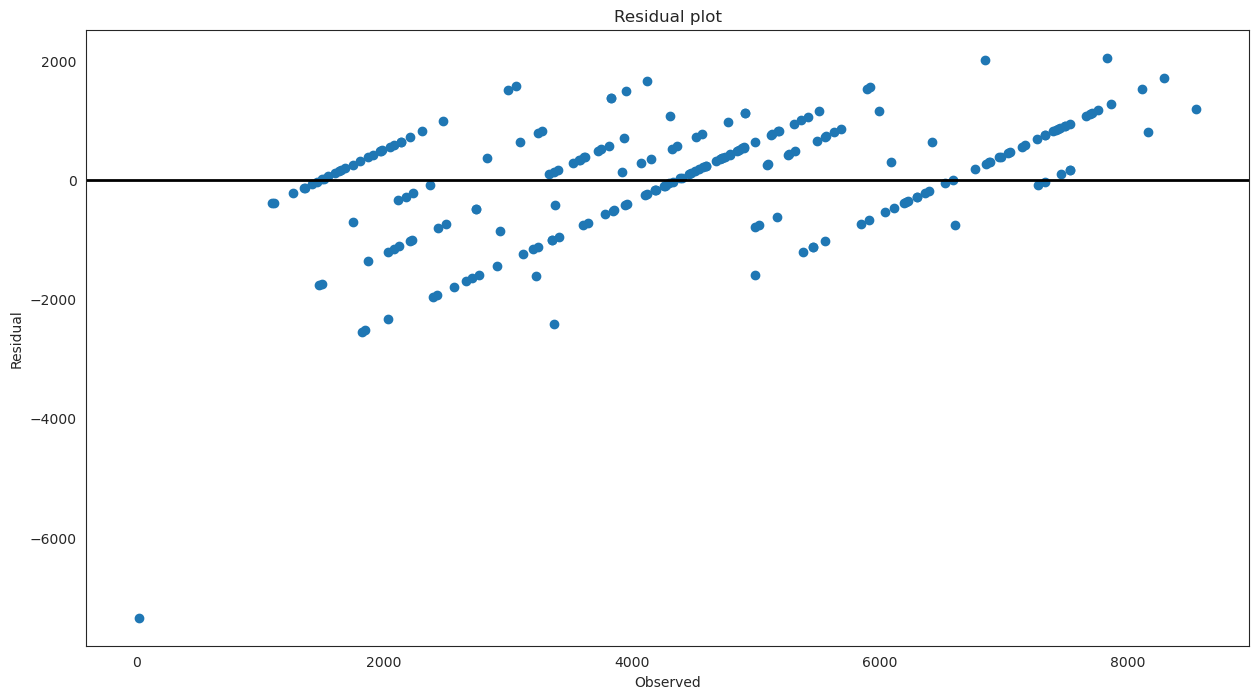

In [54]:
#Residual scatter plot
residuals = y_test-dtr_pred
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(y_test, residuals)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
ax.set_title('Residual plot')
plt.show()

Residual plot tells about finite variance between actual target value and predicted target value. In this plot, some data points are have same finite variance between them and for some are not have it.

**Random Forest**

In [55]:
#Training the model
from xgboost import XGBRegressor

# Training the model
X_train = train_encoded_attributes
rf = XGBRegressor(n_estimators=200, enable_categorical=True)


**Fit the model**

In [56]:
#Fit the trained model
rf.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

**Random forest accuracy score**

In [57]:
#accuracy of the model
rf_score =rf.score(X_train,y_train)
print('Accuracy of the model :',rf_score)

Accuracy of the model : 1.0


**Cross validation prediction**

In [58]:
#Cross validation prediction
predict=cross_val_predict(rf,X_train,y_train,cv=3)
predict

array([5145.894  , 4312.1685 , 4816.8164 , 1310.6584 , 6170.3535 ,
       4850.515  , 5415.225  , 3499.1838 , 3701.9756 , 5781.708  ,
       3679.8848 , 4289.026  , 7015.6016 , 3851.6655 , 6409.0146 ,
       6785.903  , 2841.8088 , 1113.4805 , 1515.1316 , 6139.4556 ,
       6661.8877 , 4356.63   , 4240.291  , 6043.7026 , 5799.252  ,
       2621.656  , 4678.0767 , 4746.1504 , 1165.5095 , 1679.4841 ,
       1544.6066 , 1628.2971 , 4601.4023 , 6783.867  , 6997.741  ,
       2249.319  , 1615.4236 , 2645.5532 , 4462.1426 , 6413.1084 ,
       6722.6025 , 4275.392  , 7398.154  , 6016.334  , 4546.3438 ,
       7012.69   , 1224.8586 , 4683.204  , 4769.8022 , 3460.21   ,
       3617.914  , 2074.0862 , 5386.546  , 6498.809  , 6246.5234 ,
       2189.33   , 1191.0098 , 3563.7688 ,  903.2001 , 4586.3115 ,
       6177.545  , 4324.404  , 7857.5415 , 5329.4517 , 4762.8257 ,
       6758.183  , 4314.759  , 3859.0828 , 6526.8213 , 6494.9224 ,
       2547.1106 , 4491.7925 , 7215.6274 , 3983.9836 , 4598.47

**Cross validation prediction plot**

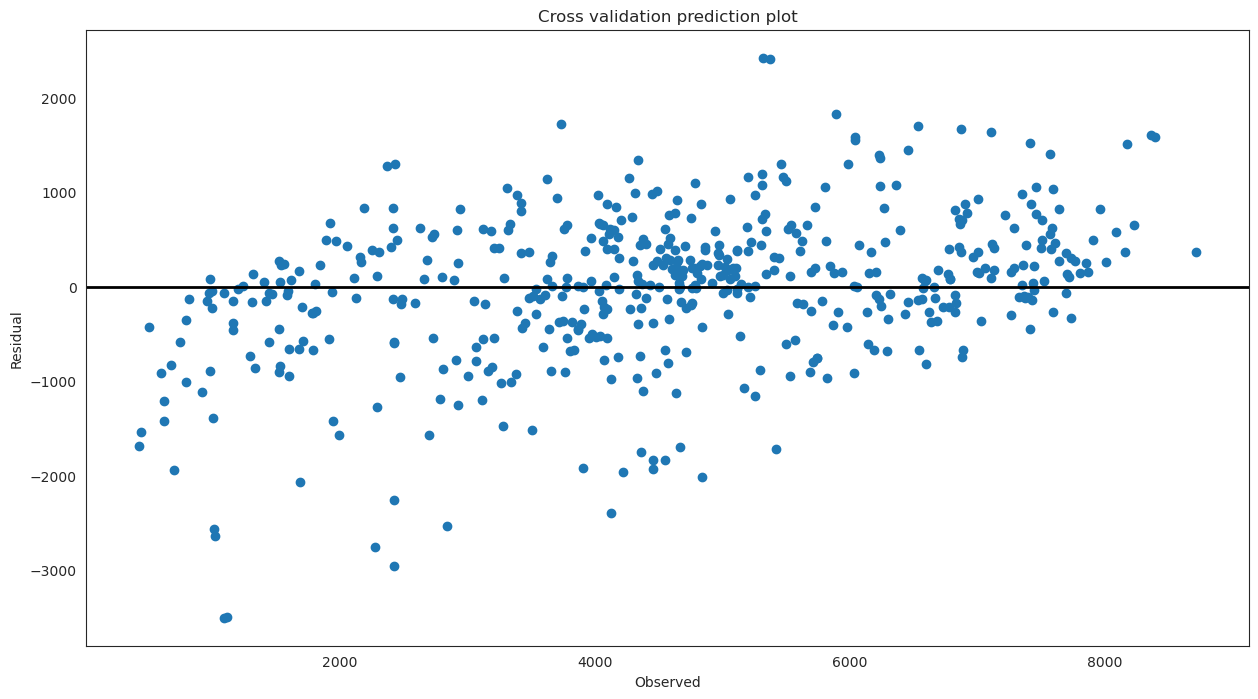

In [59]:
#Cross validation prediction plot
fig,ax=plt.subplots(figsize=(15,8))
ax.scatter(y_train,y_train-predict)
ax.axhline(lw=2,color='black')
ax.set_title('Cross validation prediction plot')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()

Cross validation prediction plot tells about finite variance between actual target value and predicted target value. In this plot,some data points are have same finite variance between them and for some are not have it.

**R-squared and mean squared error scores**

In [60]:
#R-squared scores
r2_scores = cross_val_score(rf, X_train, y_train, cv=3)
print('R-squared scores :',np.average(r2_scores))


R-squared scores : 0.8315526445706686


The R-squared or coefficient of determination is 0.85 on average for 3-fold cross validation , it means that predictor is only able to predict 85% of the variance in the target variable which is contributed by independent variables.

**Model performance on test dataset**

In [61]:
#predict the model
X_test=test_encoded_attributes
rf_pred=rf.predict(X_test)
rf_pred

array([6684.467  , 4688.9673 , 3495.603  , 2893.4792 , 7148.9863 ,
       4602.9155 , 2263.966  , 1987.2808 , 3566.6401 , 3484.5974 ,
       2996.2202 , 5016.1694 , 1970.8395 , 3307.4336 , 3972.647  ,
       2570.07   , 5642.7056 , 1519.8193 , 6902.1426 , 4144.762  ,
       3930.3352 , 3790.862  , 4939.45   , 5810.9644 , 4250.5234 ,
       4568.714  , 3980.775  , 1569.4438 , 4718.834  , 1686.529  ,
       3310.0283 , 4312.901  , 1431.8538 , 1597.0594 , 5576.5044 ,
       4312.262  , 2426.4856 , 3696.153  , 1004.20905, 8360.602  ,
       1554.0435 , 5060.924  , 5111.2734 , 7516.287  , 5178.36   ,
       3513.158  , 6469.274  , 6353.2344 , 4489.2617 , 7312.774  ,
       3724.227  , 4224.496  , 4780.367  , 4608.854  , 5127.148  ,
       7583.283  , 3475.6233 , 5830.07   , 3793.9163 , 3975.8828 ,
       1846.0936 , 4142.922  , 4570.011  , 4448.671  , 3477.0134 ,
       3155.1108 , 1636.2245 , 7338.654  , 3782.7607 , 1632.7625 ,
       5821.5703 , 4607.461  , 3271.7153 , 1662.2494 , 6767.85

**Root mean squared error and mean absolute error**

In [62]:
#Root mean square error
rmse = math.sqrt(metrics.mean_squared_error(y_test,rf_pred))
print('Root mean square error :',rmse)
#Mean absolute error
mae=metrics.mean_absolute_error(y_test,rf_pred)
print('Mean absolute error :',mae)

Root mean square error : 699.7956520013191
Mean absolute error : 472.4326442213363


**Residual plot**

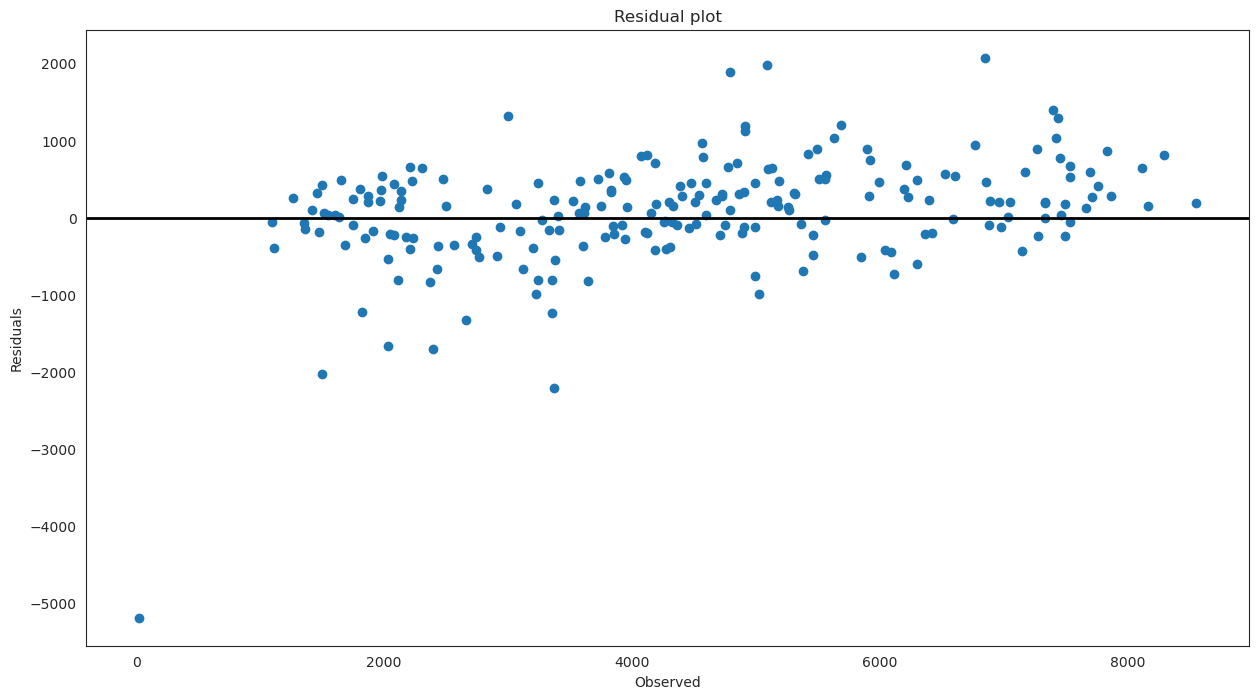

In [63]:
#Residual scatter plot
fig, ax = plt.subplots(figsize=(15,8))
residuals=y_test-rf_pred
ax.scatter(y_test, residuals)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residuals')
ax.set_title('Residual plot')
plt.show()

Cross validation prediction plot tells about finite variance between actual target value and predicted target value.In this plot,some data points are have same finite variance between them and for some are not have it.

**Final model for predicting the bike rental count on daily basis**

When we compare the root mean squared error and mean absolute error of all 3 models, the random forest model has less root mean squared error and mean absolute error. So, finally random forest model is bset for predicting the bike rental count on daily basis.

In [64]:
Bike_df1=pd.DataFrame(y_test,columns=['y_test'])
Bike_df2=pd.DataFrame(rf_pred,columns=['rf_pred'])
Bike_predictions=pd.merge(Bike_df1,Bike_df2,left_index=True,right_index=True)
Bike_predictions.to_csv('Bike_Renting_Python.csv')
Bike_predictions

,y_test,rf_pred
0,7460,6684.466797
1,4788,4688.967285
2,3331,3495.603027
3,3068,2893.479248
4,7338,7148.986328
...,...,...
214,2914,3414.170166
215,6978,7099.921875
216,7499,7739.898926
217,3855,4061.993408


# Register the model in Sagemaker Registry

In [65]:
def store_model_in_s3(model_file_name):
    # Store the uncompressed model export
    rawObj = open(model_file_name, "rb")
    key = os.path.join(ARTIFACT_DATA, model_file_name, "model")
    boto3.Session().resource("s3").Bucket(BUCKET).Object(key).upload_fileobj(rawObj)
    
    # TEST loading model to make sure it works
    booster = xgb.Booster()
    booster.load_model(model_file_name)
    print(booster.num_features())
    
    # Compress and archive model file (This should work but does not)
    !tar czvf model.tar.gz {model_file_name}
    fObj = open("model.tar.gz", "rb")
    key_tar = os.path.join(ARTIFACT_DATA, model_file_name, "model.tar.gz")
    boto3.Session().resource("s3").Bucket(BUCKET).Object(key_tar).upload_fileobj(fObj)
    return key  

In [66]:
import tarfile, joblib
import pickle as pkl

import xgboost as xgb

# WORKING - not archived, just model file
model_file_name = "demo-xgboost-model"
rf.save_model(model_file_name)
key = store_model_in_s3(model_file_name)

# Archive not working, pkl not loaded
pkl_file_name = "pkl-xgboost-model"
pkl.dump(rf, open(pkl_file_name, 'wb'))
# FAILS to import with error: XGBoostError: basic_string::_M_replace_aux
# store_model_in_s3(pkl_file_name)

# Archive not working, joblib not loaded
joblib_file_name = "joblib-xgboost-model"
joblib.dump(rf, joblib_file_name)
# FAILS to import with error: XGBoostError: basic_string::_M_replace_aux
# store_model_in_s3(pkl_file_name)

18
demo-xgboost-model


['joblib-xgboost-model']

In [68]:
import boto3
import sagemaker
from sagemaker import image_uris
from datetime import datetime
from sagemaker.model_card import ModelCard
import json
# from reportlab.lib.pagesizes import letter
# from reportlab.pdfgen import canvas

# Initialize SageMaker session
session = sagemaker.Session()
region = session.boto_region_name

# Initialize Boto3 client for SageMaker
sagemaker_client = boto3.client('sagemaker', region_name=region)

# Define the base model package group name
base_model_package_group_name = 'bike-share-model-group-rf'

# Append the current timestamp to the model package group name
timestamp = datetime.now().strftime('%Y%m%d%H%M%S')
model_package_group_name = f"{base_model_package_group_name}"

# Create a model package group
print(f"Creating model package group '{model_package_group_name}'...")
# TODO - Put this in a one-time setup area... 
# sagemaker_client.create_model_package_group(
#     ModelPackageGroupName=model_package_group_name,
#     ModelPackageGroupDescription='Model package group for bike sharing model'
# )

# Define the model artifact S3 URI and other parameters
model_artifact_s3_uri = f's3://{BUCKET}/{key}'
model_image_uri = image_uris.retrieve(framework='xgboost', region='us-east-2', version="1.7-1", image_scope='inference')
role_arn = sagemaker.get_execution_role()

# Register the model package
response = sagemaker_client.create_model_package(
    ModelPackageGroupName=model_package_group_name,
    ModelPackageDescription='Bike sharing model package',
    InferenceSpecification={
        'Containers': [
            {
                'Image': model_image_uri,
                'ModelDataUrl': model_artifact_s3_uri,
            }
        ],
        'SupportedContentTypes': ['text/csv'],
        'SupportedResponseMIMETypes': ['text/csv']
    },
    CertifyForMarketplace=False
)

# Extract the model package ARN from the response
model_package_arn = response['ModelPackageArn']

# Add the model package as a version to the model package group
sagemaker_client.update_model_package(
    ModelPackageArn=model_package_arn,
    ModelApprovalStatus='Approved'
)

print(f"Model registered in the model package group '{model_package_group_name}' successfully.")

# Create the content for the Model Card
model_card_content = {
    "model_overview": {
        "model_description": "A model to predict bike sharing demand based on various features.",
        "model_creator": "Sagemaker Group",
        "model_artifact": ["s3://sagemaker-ftb-sagemaker-domain/bike_share_data/"],
        "algorithm_type": "Multiple Linear Regression",
        "problem_type": "Regression",
        "model_owner": "Fifth Third Bank",
        "model_name": "bikestuff"
    },
    "intended_uses": {
        "purpose_of_model": "Predict bike sharing demand",
        "intended_uses": "City planners, bike sharing companies",
        "factors_affecting_model_efficiency": "Model may not perform well in extreme weather conditions"
    },
    "business_details": {
        "business_problem": "Predicting bike sharing demand to optimize resource allocation",
        "business_stakeholders": "City planners, bike sharing companies",
        "line_of_business": "Urban planning and transportation"
    },
    "training_details": {

        "training_observations": "Model trained on historical bike sharing data",
        "training_job_details": {
            "training_arn": "arn:aws:sagemaker:us-east-2:123456789012:training-job/bike-share-training-job",
            "training_datasets": ["s3://sagemaker-ftb-sagemaker-domain/bike_share_data/train/"],
            "training_environment": {
                "container_image": ["123456789012.dkr.ecr.us-east-2.amazonaws.com/sklearn:0.23-1"]
            }
        }
    },
    "evaluation_details": [
        {
            "name": "Initial Evaluation",
            "evaluation_observation": "Model evaluated on test data",
            "evaluation_job_arn": "arn:aws:sagemaker:us-east-2:123456789012:evaluation-job/bike-share-evaluation-job",
            "datasets": ["s3://sagemaker-ftb-sagemaker-domain/bike_share_data/test/"],
            "metric_groups": [
                {
                    "name": "Regression Metrics",
                    "metric_data": [
                        {
                            "name": "MSE",
                            "type": "number",
                            "value": 0.02
                        },
                        {
                            "name": "Accuracy",
                            "type": "number",
                            "value": 0.95
                        }
                    ]
                }
            ]
        }
    ],
    "additional_information": {
        "ethical_considerations": "Steps taken to mitigate bias in the model",
        "caveats_and_recommendations": "Model may not perform well in extreme weather conditions"
    }
}

# Convert the content to a JSON string
model_card_content_json = json.dumps(model_card_content)

# Create a Model Card with the content
model_card_name = f"bike-share-model-card-{timestamp}"
response = sagemaker_client.create_model_card(
    ModelCardName=model_card_name,
    ModelCardStatus='Draft',
    Content=model_card_content_json
)


# Get the Model Card ARN
model_card_arn = response['ModelCardArn']

print(f"Model Card '{model_card_name}' created and updated successfully.")

# List all Model Cards to verify creation
response = sagemaker_client.list_model_cards()
print("Listing all Model Cards:")
for card in response['ModelCardSummaries']:
    print(f"Model Card Name: {card['ModelCardName']}, ARN: {card['ModelCardArn']}")

# Describe the created Model Card to view its details
response = sagemaker_client.describe_model_card(ModelCardName=model_card_name)

# Convert datetime objects to strings in the response
def convert_datetime(obj):
    if isinstance(obj, datetime):
        return obj.strftime('%Y-%m-%dT%H:%M:%S')
    raise TypeError("Type not serializable")

print("Details of the created Model Card:")
model_card_details = json.dumps(response, indent=4, default=convert_datetime)
print(model_card_details)

# Save the Model Card details to a JSON file
json_filename = f"{model_card_name}.json"
with open(json_filename, "w") as f:
    f.write(model_card_details)

card1 = ModelCard.load(name=model_card_name, sagemaker_session=session)
s3_output_path = f"s3://{BUCKET}/{ARTIFACT_DATA}"

card1.export_pdf(s3_output_path=s3_output_path)

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix
Creating model package group 'bike-share-model-group-rf'...
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix
Model registered in the model package group 'bike-share-model-group-rf' successfully.
Model Card 'bike-share-model-card-20250225170421' created and updated successfully.
Listing all Model Cards:
Model Card Name: bike-share-model-card-20241023231857, ARN: arn:aws:sagemaker:us-east-2:642693618675:model-card/bike-share-model-card-20241023231857
Model Card Name: bike-share-model-card-20241023232036, ARN: arn:aws:sagemaker:us-east-2:642693618675:model-card/bike-share-model-card-202410232320

's3://sagemaker-domain-dev/artifacts/bike-share-model-card-20250225170421/bike-share-model-card-20250225170421-1740503063-b2fa.pdf'